In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import explore

from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression

from wrangle import wrangle_zillow_mvp, wrangle_zillow, get_zillow_mvp, prepare_zillow_mvp

# Shhhh
import warnings
warnings.filterwarnings("ignore")


#### Testing Wrangling Zillow 2017 Data Function:

My definition was having issue pulling the data at first, so this is the breakdown of a day of troubleshooting all my previous definitions to get them to work on

In [2]:
df = get_zillow_mvp()

In [3]:
df.info(), df.shape
# Without it dropping 0 bedrooms and pulling the one entry that doesn't have a 2017 date as well,
# we get the 52,442 (0 - 52,441 indexs)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52305 entries, 0 to 52441
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   52305 non-null  float64
 1   bathrooms  52305 non-null  float64
 2   area       52297 non-null  float64
 3   tax_value  52304 non-null  float64
 4   date       52305 non-null  object 
dtypes: float64(4), object(1)
memory usage: 2.4+ MB


(None, (52305, 5))

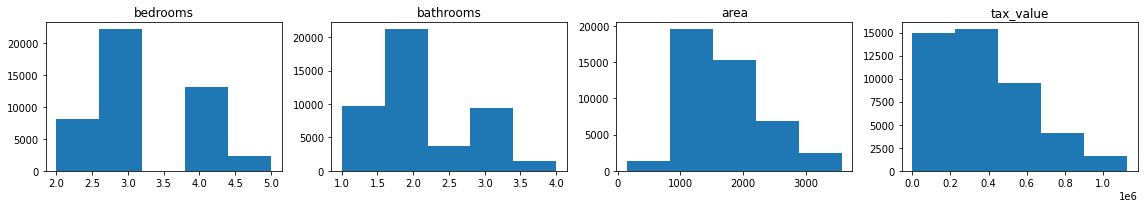

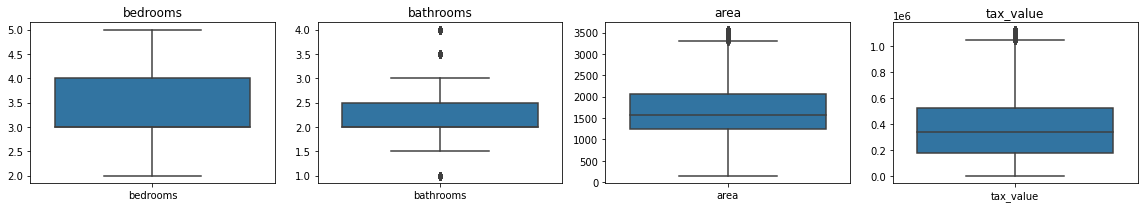

In [4]:
train, validate, test = prepare_zillow_mvp(df)

In [5]:
# All nulls have been cleared from the data and it's been split into Train, Validate, And Test.
# Time to check the full function.

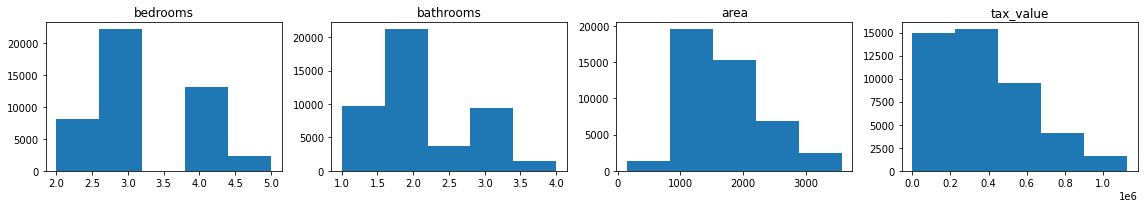

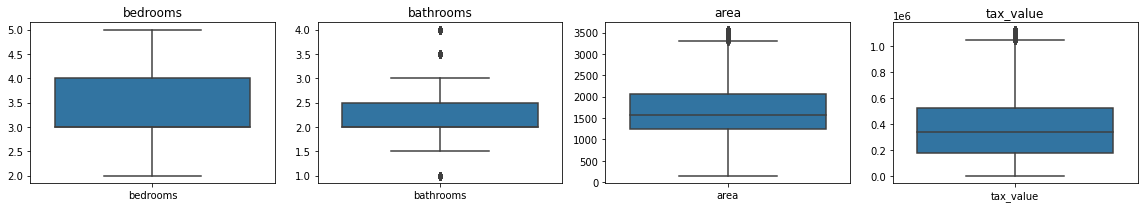

In [6]:
train, validate, test = wrangle_zillow_mvp()

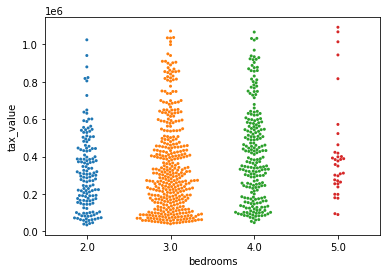

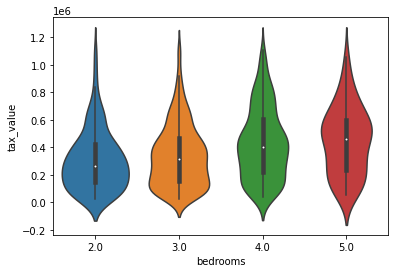

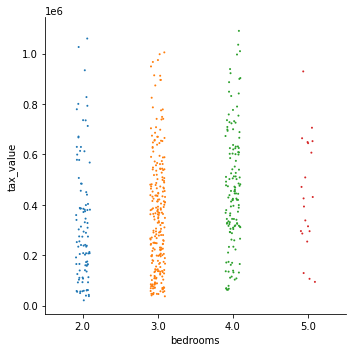

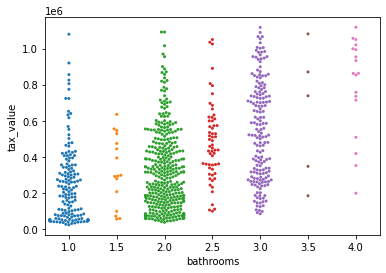

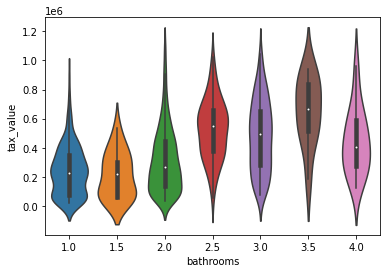

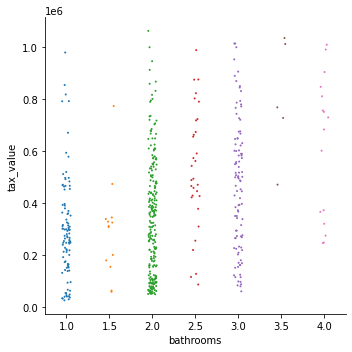

In [7]:
explore.plot_categorical_and_continuous_vars(train)

-=== bedrooms ===-
 
Value Counts:
-------------
3.0    12383
4.0     7262
2.0     4555
5.0     1350
Name: bedrooms, dtype: int64
 
Percent of Total:
-----------------
3.0    48.465753
4.0    28.422701
2.0    17.827789
5.0     5.283757
Name: bedrooms, dtype: float64
 
 >> P is less than Alpha.
 


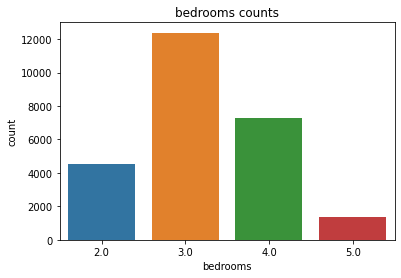

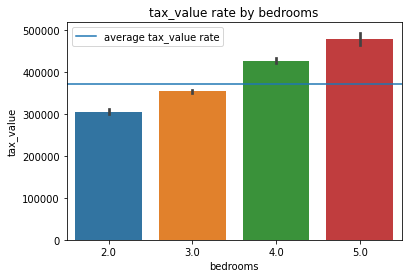

 
 
-=== bathrooms ===-
 
Value Counts:
-------------
2.0    11897
3.0     5302
1.0     4942
2.5     2068
4.0      595
1.5      487
3.5      259
Name: bathrooms, dtype: int64
 
Percent of Total:
-----------------
2.0    46.563601
3.0    20.751468
1.0    19.342466
2.5     8.093933
4.0     2.328767
1.5     1.906067
3.5     1.013699
Name: bathrooms, dtype: float64
 
 >> P is less than Alpha.
 


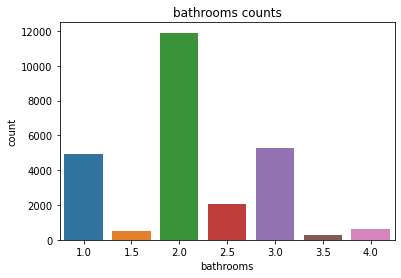

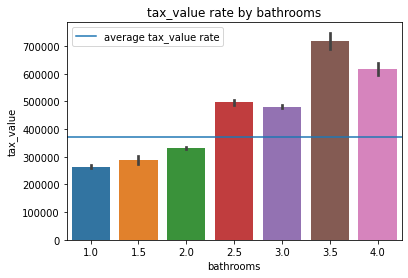

 
 
-=== tax_value ===-
 
Tax Value Average:
$ 372885.47
-------------


In [8]:
explore.explore_cat(train)

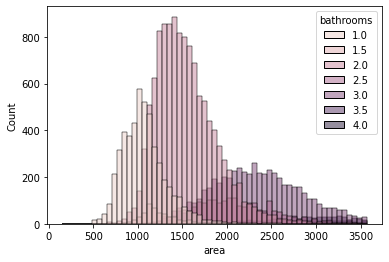

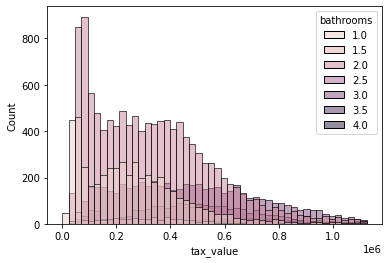

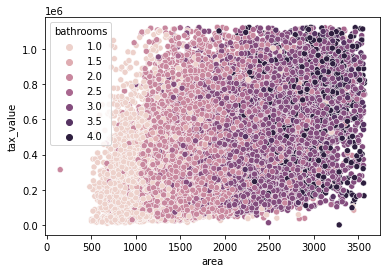

In [9]:
explore.explore_num(train)

#### Stats Testing:

##### H0:
    There is no Correlation between [Bedrooms, Bathrooms, Area] and Tax Value.
##### Ha:
    There is a Correlation between [Bedrooms, Bathrooms, Area] and Tax Value.

-------

There seems to be the lowest correlation between # of Bedrooms and Tax Value, where as there's slightly higher for Bathrooms and Tax Value, and the most (only .44 out of 1 though) between Area and Tax Value.
I'm curious since there's a larger correlation between Bathrooms and Area if I did the Area, divided by bathrooms, then checked Correlation what it would be.

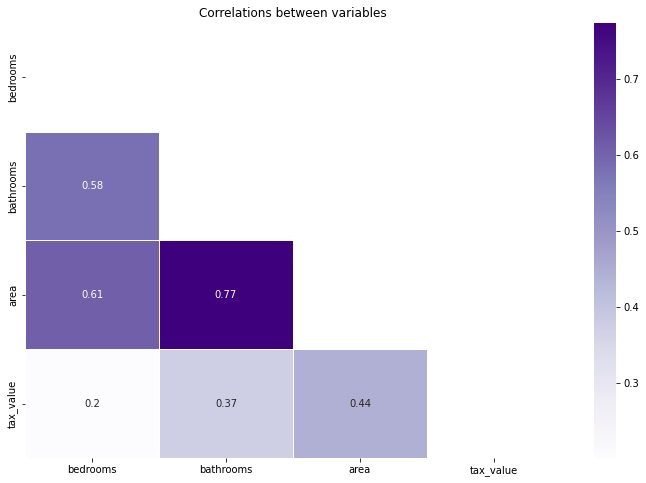

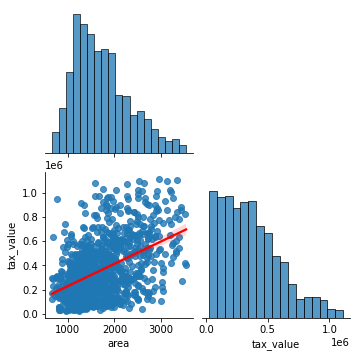

In [10]:
explore.plot_variable_pairs(train)

------

#### H0:
    There is no correlation between area by bathroom

In [11]:
# Bathrooms and Area Figure
train['area_by_bathroom'] = train['area']/train['bathrooms']

In [12]:
train.head()

,bedrooms,bathrooms,area,tax_value,area_by_bathroom
16298,3.0,2.0,1631.0,94598.0,815.5
48457,4.0,2.0,1215.0,381640.0,607.5
52376,3.0,2.0,1671.0,208141.0,835.5
6335,2.0,2.0,1788.0,411393.0,894.0
8395,3.0,2.0,2605.0,561561.0,1302.5


In [13]:
corr, p = stats.spearmanr(train.area_by_bathroom, train.tax_value)
round(corr, 2), p

(0.07, 1.2694905890428193e-27)

woo, definitely not.

In [14]:
train['area_by_beds'] = train['area']/train['bedrooms']

In [15]:
train.head()

,bedrooms,bathrooms,area,tax_value,area_by_bathroom,area_by_beds
16298,3.0,2.0,1631.0,94598.0,815.5,543.666667
48457,4.0,2.0,1215.0,381640.0,607.5,303.750000
52376,3.0,2.0,1671.0,208141.0,835.5,557.000000
6335,2.0,2.0,1788.0,411393.0,894.0,894.000000
8395,3.0,2.0,2605.0,561561.0,1302.5,868.333333


In [16]:
corr, p = stats.spearmanr(train.area_by_beds, train.tax_value)
round(corr, 2), p

(0.34, 0.0)

Better than Bedrooms alone at least.

What about Bedrooms and Bathrooms together?

In [17]:
train["bed_and_bath"] = train['bedrooms'] + train['bathrooms']
train.head()

,bedrooms,bathrooms,area,tax_value,area_by_bathroom,area_by_beds,bed_and_bath
16298,3.0,2.0,1631.0,94598.0,815.5,543.666667,5.0
48457,4.0,2.0,1215.0,381640.0,607.5,303.750000,6.0
52376,3.0,2.0,1671.0,208141.0,835.5,557.000000,5.0
6335,2.0,2.0,1788.0,411393.0,894.0,894.000000,4.0
8395,3.0,2.0,2605.0,561561.0,1302.5,868.333333,5.0


In [18]:
corr, p = stats.spearmanr(train.bed_and_bath, train.tax_value)
round(corr, 2), p

(0.32, 0.0)

-------

In [19]:
train["rooms_and_area"] = train['bed_and_bath']/train.area

In [20]:
train.head()

,bedrooms,bathrooms,area,tax_value,area_by_bathroom,area_by_beds,bed_and_bath,rooms_and_area
16298,3.0,2.0,1631.0,94598.0,815.5,543.666667,5.0,0.003066
48457,4.0,2.0,1215.0,381640.0,607.5,303.750000,6.0,0.004938
52376,3.0,2.0,1671.0,208141.0,835.5,557.000000,5.0,0.002992
6335,2.0,2.0,1788.0,411393.0,894.0,894.000000,4.0,0.002237
8395,3.0,2.0,2605.0,561561.0,1302.5,868.333333,5.0,0.001919


In [21]:
corr, p = stats.spearmanr(train.rooms_and_area, train.tax_value)
round(corr, 2), p

(-0.29, 0.0)

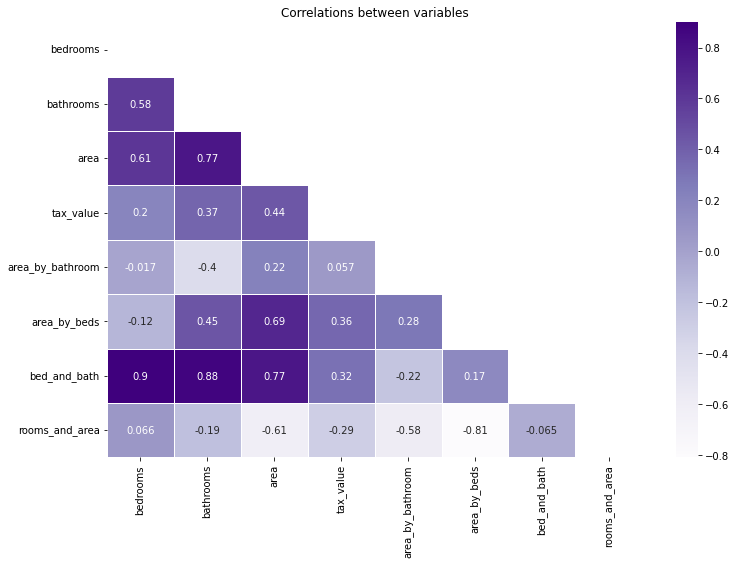

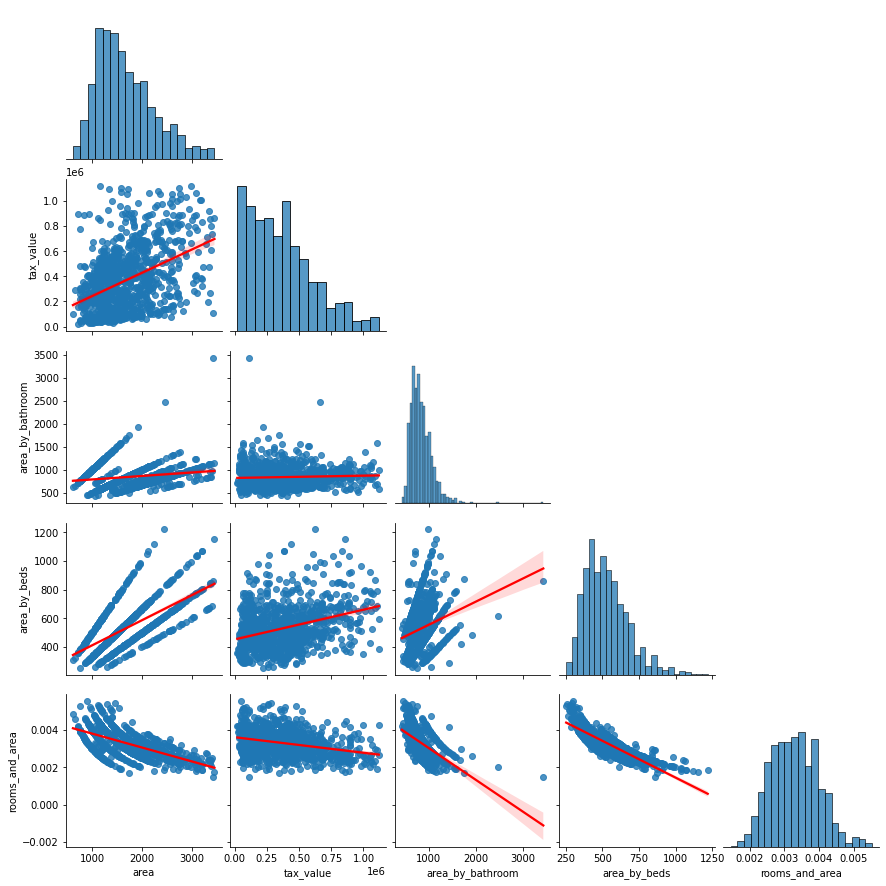

In [22]:
explore.plot_variable_pairs(train,num= ['area', 'tax_value', 'area_by_bathroom', 'area_by_beds', 'rooms_and_area'])

Tax Value and Area still have the best correlation.

-------

Going to see if my assessment is correct.

In [23]:
X_train = train.drop(columns="tax_value")
y_train = train.tax_value
explore.select_best(X_train, y_train, 2)

KBest:
['bathrooms', 'area']
None
 
RFE:
['bedrooms', 'bed_and_bath']
None
 
SFS:
['bedrooms', 'area']
None


I'm interested to see what models doing something like bedrooms and bedbath would do.

In [24]:
X_train, y_train = train.drop(columns="tax_value"), train.tax_value
X_validate, y_validate = validate.drop(columns="tax_value"), validate.tax_value
X_test, y_test = test.drop(columns="tax_value"), test.tax_value
y_train.mean()

372885.46673189825

In [25]:
y_train.head()

16298     94598.0
48457    381640.0
52376    208141.0
6335     411393.0
8395     561561.0
Name: tax_value, dtype: float64

In [26]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [27]:
y_train.head()

,tax_value
16298,94598.0
48457,381640.0
52376,208141.0
6335,411393.0
8395,561561.0


In [28]:
y_train['baseline_mean'] = y_train['tax_value'].mean()
y_train['baseline_median'] = y_train['tax_value'].median()

# scores:
rmse_mean = mean_squared_error(y_train.tax_value,
                               y_train['baseline_mean'], squared=False)
rmse_med = mean_squared_error(y_train.tax_value,
                               y_train['baseline_median'], squared=False)

print("RMSE Mean:")
print(rmse_mean)
print("----------------")
print("RMSE Median:")
print(rmse_med)

RMSE Mean:
243788.25256933476
----------------
RMSE Median:
246328.52244123278


In [29]:
explore.get_rmse(y_train, 'tax_value')

RMSE Mean:
243788.25256933476
----------------
RMSE Median:
246328.52244123278
----------------
RMSE Mean is lower so we'll use that : 243788.25256933476
